# SUR Model: Chicago Food Access Pre/Post Great Recession 

See SUR documentation here: http://pysal.readthedocs.io/en/latest/library/spreg/sur.html


### Open required libraries

In [1]:
import pysal

In [2]:
import sys
sys.path.append('/Users/Masia/Code/spreg')

In [15]:
from sur import SUR
from sur import BaseThreeSLS
from diagnostics_sur import sur_setp, sur_chow, sur_joinrho
from sur_utils import check_k
from sur_utils import sur_dictxy,sur_dict2mat,sur_mat2dict,sur_corr,sur_crossprod,sur_est,sur_resids,sur_predict,check_k

In [20]:
from sur_lag import SURlagIV


In [4]:
import numpy as np
import numpy.linalg as la
import scipy.stats as stats
import summary_output as SUMMARY
from diagnostics_sur import sur_setp,sur_lrtest,sur_lmtest,surLMe,surLMlag,sur_chow

In [44]:
import numpy as np
import pysal
import numpy.linalg as la
import scipy.stats as stats
import summary_output as SUMMARY
import user_output as USER
from scipy.sparse.linalg import splu as SuperLU
from scipy.optimize import minimize_scalar, minimize
from scipy import sparse as sp
from sur_utils import sur_dictxy,sur_corr,sur_dict2mat,\
               sur_crossprod,sur_est,sur_resids,filter_dict,\
               check_k
from sur import BaseSUR
from diagnostics_sur import sur_setp, lam_setp, sur_chow
from regimes import buildR,wald_test

In [46]:
from sur_error import SURerrorML


### Open DBF file for Analysis

In [5]:
db = pysal.open("/Users/Masia/Desktop/FinalChiCluster.dbf")

### Build Spatial Weight

In [6]:
## Queen-Contiguity Spatial Weight generated
w = pysal.queen_from_shapefile("/Users/Masia/Desktop/FinalChiCluster.shp")
w.transform='r'

### Generate List of Variables

In [7]:
## Log (Network Distance Miles to Supermarkets / Population of Tract)
y_var = ['FA07RT','FA11RT']

## Covariates: Log(PerCap Income), Dummy Variables for Race, Excess Risk for Foreclosure as Treatment)
x_var=[['LINC10','BlackMaj10','WHITEMAJ10','HispMaj10'],
       ['LINC12','BLKMAJ12','WHITEMAJ12','HISPMAJ12']]

### Build Variable Dictionaries

In [8]:
#bigy,bigX,bigyvars,bigXvars = pysal.spreg.sur_utils.sur_dictxy(db,y_var,x_var)
bigy,bigX,bigyvars,bigXvars = sur_dictxy(db,y_var,x_var)

### Run SUR Regressions

In [9]:
#reg = pysal.spreg.sur.SUR(bigy,bigX,w=w,name_bigy=bigyvars,name_bigX=bigXvars,
#                          spat_diag=True,name_ds="nat",name_w=w)

reg = pysal.spreg.sur.SUR(bigy,bigX,w=w,name_bigy=bigyvars,name_bigX=bigXvars,
                          spat_diag=True,name_ds="nat",name_w=w)

print(reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SEEMINGLY UNRELATED REGRESSIONS (SUR)
--------------------------------------------------------
Data set            :         nat
Weights matrix      :<pysal.weights.weights.W object at 0x1152c3550>
Number of Equations :           2                Number of Observations:         791
Log likelihood (SUR):     258.173                Number of Iterations  :           1
----------

SUMMARY OF EQUATION 1
---------------------
Dependent Variable  :      FA07RT                Number of Variables   :           5
Mean dependent var  :     -3.5984                Degrees of Freedom    :         786
S.D. dependent var  :      0.3653

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          Constant_1      -3.4323307       0.2140851     -16.0325536       

In [22]:
SSUR = pysal.spreg.SURlagIV(bigy,bigX,w=w,name_bigy=bigyvars,name_bigX=bigXvars,
                          spat_diag=True,name_ds="nat",name_w=w,lag_q=True,)

print(SSUR.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SEEMINGLY UNRELATED REGRESSIONS (SUR) - SPATIAL LAG MODEL
----------------------------------------------------------------------------
Data set            :         nat
Weights matrix      :<pysal.weights.weights.W object at 0x1152c3550>
Number of Equations :           2                Number of Observations:         791
----------

SUMMARY OF EQUATION 1
---------------------
Dependent Variable  :      FA07RT                Number of Variables   :           6
Mean dependent var  :     -3.5984                Degrees of Freedom    :         785
S.D. dependent var  :      0.3653

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          Constant_1      -1.4757706       0.2948965      -5.0043677       0.0000006
              LINC10       0.107216

In [48]:
SSUR_Error = pysal.spreg.SURerrorML(bigy,bigX,w=w,name_bigy=bigyvars,name_bigX=bigXvars,
                          spat_diag=True,name_ds="nat",name_w=w,)

print(SSUR_Error.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SEEMINGLY UNRELATED REGRESSIONS (SUR) - SPATIAL ERROR MODEL
------------------------------------------------------------------------------
Data set            :         nat
Weights matrix      :<pysal.weights.weights.W object at 0x1152c3550>
Number of Equations :           2                Number of Observations:         791
Log likelihood (SUR):     275.446
Log likel. (error)  :    -153.709                Log likel. (SUR error):     642.910
----------

SUMMARY OF EQUATION 1
---------------------
Dependent Variable  :      FA07RT                Number of Variables   :           5
Mean dependent var  :     -3.5984                Degrees of Freedom    :         786
S.D. dependent var  :      0.3653

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------------------------------------------------------------

## Y Observed

In [12]:
#dictionary with Y values
#reg.bigy

In [23]:
# Stack columns of the dictionary
d = reg.bigy
y_obs = np.concatenate(list(d.values()))

In [24]:
len(y_obs)

1582

In [25]:
type(y_obs)

numpy.ndarray

In [26]:
y_obs.shape

(1582, 1)

In [27]:
y_obs

array([[-3.4277097],
       [-3.9734022],
       [-3.7219685],
       ..., 
       [-3.5524868],
       [-3.5689059],
       [-3.7360896]])

## Y Predicted

In [28]:
# Generate matrix for predicted Y
bSUR,varb,sig = sur_est(reg.bigXX,reg.bigXy,reg.olsE,reg.bigK)
bigYP = sur_predict(bigy,bigX,bSUR)

In [29]:
type(bigYP)

numpy.ndarray

In [30]:
y_exp = np.hstack(bigYP)

In [31]:
len(y_exp)

1582

In [32]:
type(y_exp)

numpy.ndarray

In [33]:
y_exp.shape

(1582,)

In [34]:
y_exp.resize((1582, 1))

In [35]:
y_exp.shape

(1582, 1)

In [36]:
y_exp

array([[-3.41672313],
       [-3.40732213],
       [-3.72425997],
       ..., 
       [-3.40233745],
       [-3.71780108],
       [-3.72158331]])

## Plot Observed vs Predicted Y

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

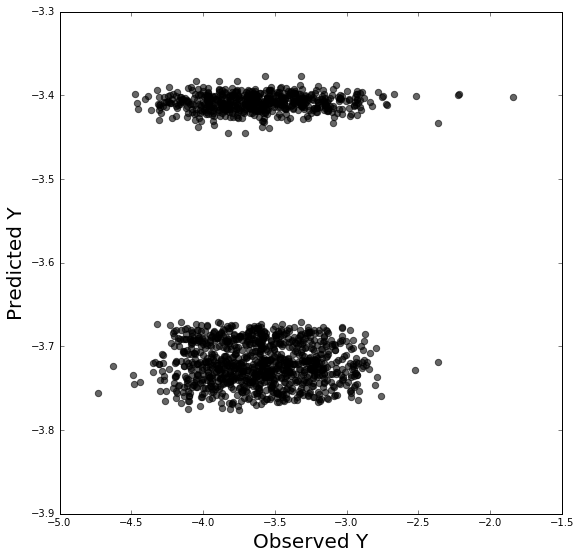

In [38]:
#custom 
fig = plt.figure(figsize=(9,9))
plt.scatter(y_obs,y_exp, c='k', s=40, alpha=.6)
plt.xlabel("Observed Y", fontsize=20)
plt.ylabel("Predicted Y", fontsize=20)

plt.show()

## Calculate Crude R Squared 

In [39]:
cor = stats.pearsonr(y_obs,y_exp)

In [40]:
cor

(array([-0.00823955]), array([ 0.74331293]))

In [41]:
Rsquare = 0.74331293**2

In [42]:
Rsquare

0.5525141119051848